# MOLE DETECTION  -- Binary --

#### Import Necessary Libraries

In [6]:
import os
import numpy as np
import pandas as pd

from PIL import Image
from glob import glob
import itertools
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

#### Define default variables

In [7]:
# DATA_DIR = os.path.join('.', 'data')
# IMAGE_DIR = os.path.join('.', 'data\\images\\')
# PATHS ARE ALREADY IN CSV
#All images are 640 x 480  
# 2	    3	    4	5
# 300	200	150	    120
# 225	150	112.5	90

XPIXEL=120
YPIXEL=90


label_mapping = {
    0: 'benign',
    1: 'malignant'
}


int_label_mapping = dict((value, key) for key, value in label_mapping.items())

#### Import the data 

In [8]:
data = pd.read_csv('_prop.csv')
data.head(5)


,image_id,bm,dx,path,del
0,ISIC_0013758,benign,nevus,.\data\images\ISIC_0013758.JPG,NaN
1,ISIC_0031501,benign,nevus,.\data\images\ISIC_0031501.JPG,NaN
2,ISIC_0026882,benign,nevus,.\data\images\ISIC_0026882.JPG,NaN
3,ISIC_0026897,malignant,melanoma,.\data\images\ISIC_0026897.JPG,NaN
4,ISIC_0072431,malignant,basal cell carcinoma,.\data\images\ISIC_0072431.JPG,NaN


In [9]:
data = data[data['dx'].notna()]


In [29]:
data['bm'].value_counts()
data['dx'].value_counts()

nevus                      12143
melanoma                    5475
basal cell carcinoma        3392
squamous cell carcinoma      656
Name: dx, dtype: int64

In [11]:
# read pixel data to dataframe
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((XPIXEL,YPIXEL))))

In [12]:
# Converting labels to 0 and 1
data['label'] = data['bm'].map(int_label_mapping.get)


In [13]:
data.head(5)

,image_id,bm,dx,path,del,image_pixel,label
0,ISIC_0013758,benign,nevus,.\data\images\ISIC_0013758.JPG,NaN,"[[[40, 39, 44], [39, 38, 44], [40, 39, 46], [3...",0
1,ISIC_0031501,benign,nevus,.\data\images\ISIC_0031501.JPG,NaN,"[[[161, 136, 144], [163, 138, 152], [162, 139,...",0
2,ISIC_0026882,benign,nevus,.\data\images\ISIC_0026882.JPG,NaN,"[[[215, 133, 147], [216, 133, 148], [216, 134,...",0
3,ISIC_0026897,malignant,melanoma,.\data\images\ISIC_0026897.JPG,NaN,"[[[188, 153, 151], [194, 158, 156], [195, 165,...",1
4,ISIC_0072431,malignant,basal cell carcinoma,.\data\images\ISIC_0072431.JPG,NaN,"[[[138, 85, 75], [142, 94, 82], [147, 103, 89]...",1


### Create X , Y

In [14]:
#data = data.sample(frac = 1)
# ORIGINAL
# Convert image pixel columnm into numpy array
X = data['image_pixel'].to_numpy()
X = np.stack(X, axis=0)
Y = np.array(data['label'])
Y = np.stack(Y,axis=0)   # no need
print(X.shape)
print(Y.shape)

(21666, 90, 120, 3)
(21666,)


In [15]:
def train_test(X, Y):
    # train test split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42,shuffle=True)
    
    return X_train, X_test, Y_train, Y_test

In [16]:
def create_model():
    model = Sequential()
    
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (YPIXEL, XPIXEL, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    #model.add(Dense(8, activation='relu'))
    

    model.add(Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)  #### learnign rate???? 

    model.compile(loss = 'binary_crossentropy',
                 optimizer = "adam",
                  metrics = ['accuracy'])
    print(model.summary())
    return model

In [17]:
def train_model(model:Sequential, X_tr, Y_tr, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1,mode='auto')
                               
    
    learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')
    
    history = model.fit(X_tr, Y_tr, validation_split=0.2, batch_size = 24, epochs = EPOCHS,callbacks = [learning_rate, early_stop])
    return history

In [18]:
def test_model(model:Sequential, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred=np.round(y_pred,0)
    #y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    cm=confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm,label_mapping,"44")
    print(cm)

    plt.show() 

In [19]:
def plot_confusion_matrix(cm, classes, name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

   
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
    fig.savefig('_confusion_matrix.png', dpi=300)

### Create train and test datas for original and augumented datasets

In [20]:
# For Original Dataset
X_train, X_test, Y_train, Y_test = train_test(X, Y)
#Augemented dataset
#X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = train_test(X_aug, Y_aug)
print(X_train.shape)
#print(X_train_aug.shape)



(17332, 90, 120, 3)


### Create the Model

In [21]:
model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 90, 120, 16)       448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 60, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 60, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 30, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 15, 64)       0

In [22]:
model_history = train_model(model, X_train, Y_train, 50)

Epoch 1/50
578/578 [==============================] - 22s 32ms/step - loss: 0.5761 - accuracy: 0.7292 - val_loss: 0.4712 - val_accuracy: 0.7747 - lr: 0.0010
Epoch 2/50
578/578 [==============================] - 17s 30ms/step - loss: 0.4508 - accuracy: 0.7817 - val_loss: 0.3767 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 3/50
578/578 [==============================] - 18s 31ms/step - loss: 0.3941 - accuracy: 0.8066 - val_loss: 0.3690 - val_accuracy: 0.8177 - lr: 0.0010
Epoch 4/50
578/578 [==============================] - 18s 30ms/step - loss: 0.3763 - accuracy: 0.8191 - val_loss: 0.3842 - val_accuracy: 0.8050 - lr: 0.0010
Epoch 5/50
578/578 [==============================] - 18s 30ms/step - loss: 0.3569 - accuracy: 0.8324 - val_loss: 0.3595 - val_accuracy: 0.8336 - lr: 0.0010
Epoch 6/50
578/578 [==============================] - 16s 27ms/step - loss: 0.3445 - accuracy: 0.8379 - val_loss: 0.3722 - val_accuracy: 0.8238 - lr: 0.0010
Epoch 7/50
578/578 [==============================] - 18s 

#### Loss and accuracy curves for training and test sets. copied from stackoverflow

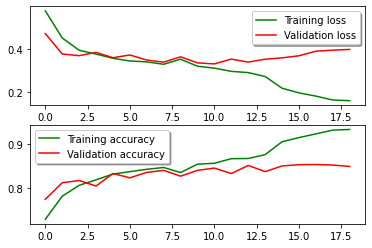

In [23]:
g, ax = plt.subplots(2,1)
ax[0].plot(model_history.history['loss'], color='g', label="Training loss")
ax[0].plot(model_history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(model_history.history['accuracy'], color='g', label="Training accuracy")
ax[1].plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Saving the model for deployment 

In [256]:
model_json = model.to_json()
with open("modelbm.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("modelbm.h5")

### Test Model

Test Accuracy: 84.772%
              precision    recall  f1-score   support

      benign       0.87      0.86      0.87      2466
   malignant       0.82      0.83      0.83      1868

    accuracy                           0.85      4334
   macro avg       0.84      0.85      0.85      4334
weighted avg       0.85      0.85      0.85      4334

[[2116  350]
 [ 310 1558]]


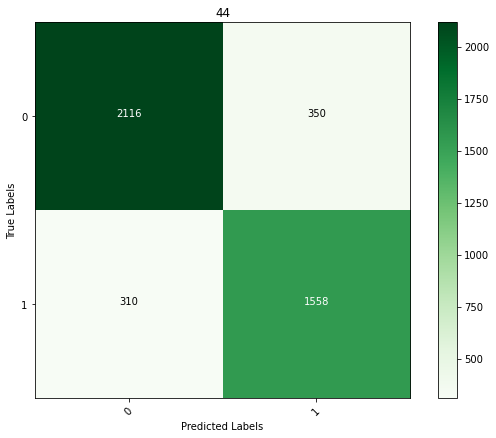

In [25]:
test_model(model, X_test, Y_test)

### Prediction for only one image

In [26]:
def predict_one_image(image_nr):

    predict_only_one = data.iloc[image_nr]
    print("Imid :" ,predict_only_one.image_id)
    print("Real :" ,predict_only_one.bm)
    
    new_one = predict_only_one.image_pixel.reshape((1,90,120,3))
    preds=model.predict(new_one)[0][0]
    
    max_index_col = np.round(preds,0)

    if preds<0.5:
        preds=1-preds
        

    pred_probabilty = " % {:.2f}".format(preds*100)
    preds=np.round(preds,0)
       
    result=label_mapping.get(max_index_col) + pred_probabilty
    print("Pred :", result)

    sample_data = predict_only_one['image_pixel']
    plt.figure(figsize=(10, 10))
    plt.imshow(sample_data)
    plt.axis("off")
    plt.show() 


Imid : ISIC_0030225
Real : benign
Pred : benign % 95.33


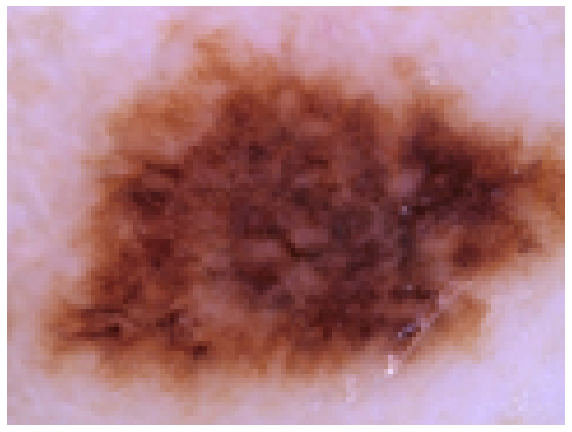

In [27]:
predict_one_image(18)